# IMPORT LIBRARIES

In [8]:
# from rdflib import Graph, URIRef, Literal, RDF
import open3d as o3d
import os
from pathlib import Path
import numpy as np
import laspy
import cv2
import copy

#IMPORT MODULES
from context import geomapi 
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
import geomapi.tools as tl
from geomapi.utils import imageutils as iu

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# INPUTS

In [4]:
xmlPath = 'D:/Data/TUCRAIL/cameras_L72_0312.xml'
imgGraphPath = "D:/Data/TUCRAIL/cameras_L72_0312.ttl" # RDF graph
meshPath='D:/Data/TUCRAIL/1203.obj'
lasPath='D:/Data/TUCRAIL/Project_2022-10-03_11-08-dense_point_cloud - Cloud.las'
imagePath='D:/Data/TUCRAIL/P0024625.jpg'
lambertCoordinates=np.array([[263377.98,151064.413,256.924,1]]) # REF-44
imgNames=['P0024624','P0024625','P0024628','P0024688','P0024689','P0024691']

In [5]:
# # geospatial offest
# transform=np.array([[1,0,0,-709963.00],
#                     [0,1,0,-5616116.00],
#                     [0,0,1,-307.00],
#                     [0,0,0,1]])

# PARSE DATA

import xml and convert to nodes

In [6]:
imgNodes=tl.img_xml_to_nodes(xmlPath,filterByFolder=True)
imgNodes=[n for n in imgNodes if n.cartesianTransform is not None]
meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]
print (f' {len(imgNodes)} Nodes created!')

 12 Nodes created!


In [7]:
#filter list because it contains doubles
names=[n.name for n in imgNodes]
myNodes=[]
for name in list(set(names)):
    myNodes.append(next(n for n in imgNodes if n.name == name))
imgNodes=myNodes
temp=[n.get_resource() for n in imgNodes]

import mesh

In [8]:
meshNode=MeshNode(path=meshPath,getResource=True)

import point cloud 

In [9]:
las  = laspy.read(lasPath)
pcdNode=PointCloudNode(resource=gmu.las_to_pcd(las))

#apply global transformation to put it in a local coordinate system
# pcdNode.geospatialTransform=transform
# pcdNode.resource.transform(transform)
print( pcdNode.resource)

PointCloud with 10039073 points.


In [10]:
#oproepen wat er allemaal in een klasse zit
{key:value for key, value in imgNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 11664,
 'imageHeight': 8750,
 'focalLength35mm': 21276.5957031249,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///8d4c8224-d489-11ed-a002-c8f75043ce59'),
 '_graph': None,
 '_graphPath': None,
 '_path': 'D:/Data/TUCRAIL/P0024628.jpg',
 '_name': 'P0024628',
 '_timestamp': None,
 '_resource': array([[[ 91,  91,  91],
         [ 92,  90,  90],
         [ 96,  94,  94],
         ...,
         [ 43,  44,  42],
         [ 41,  41,  41],
         [ 47,  47,  47]],
 
        [[ 94,  92,  92],
         [ 91,  91,  91],
         [ 94,  92,  92],
         ...,
         [ 40,  38,  37],
         [ 36,  34,  33],
         [ 45,  45,  45]],
 
        [[ 90,  88,  88],
         [ 95,  93,  93],
         [ 95,  93,  93],
         ...,
         [ 28,  26,  26],
         [ 44,  42,  41],
         [ 59,  60,  58]],
 
        ...,
 
        [[ 95, 100, 103],
         [ 97, 100, 105],
    

visualize data

In [11]:
joinedImages=gmu.join_geometries(meshes)
joinedImages=joinedImages.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([joinedImages]+[meshNode.resource])
# o3d.visualization.draw_geometries([pcdNode.resource])

# PROJECT 3D COORDINATES IN IMAGES

visualize 3D point

In [13]:
centers=np.array([gmu.get_translation(n.cartesianTransform) for n in imgNodes])
points=np.vstack((lambertCoordinates[:,0:3],centers))

#create lines
lines=[]
start=np.arange(start=1,stop=points.shape[0] )[..., np.newaxis]
end=np.zeros((points.shape[0]-1,1 ))
lines = np.hstack((start, end))

#create lineset
line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector(points)
line_set.lines = o3d.utility.Vector2iVector(lines)

o3d.visualization.draw_geometries([line_set]+[joinedImages]+[meshNode.resource])

convert lambertCoordinates to uvCoordinates for the images

In [14]:
#lambert to imagecoordinates
uvCoordinates=[]
for n in imgNodes:

    # transform world coordinates to imageCoordinates
    imageCoordinates= np.linalg.inv(n.cartesianTransform) @ lambertCoordinates.T
    # print(imageCoordinates)

    #transform imageCoordinates to xy coordinates on the imageframe
    xy=copy.deepcopy(imageCoordinates)
    xy[0]= imageCoordinates[0]/imageCoordinates[2]*n.focalLength35mm
    xy[1]= imageCoordinates[1]/imageCoordinates[2]*n.focalLength35mm
    xy[2]= imageCoordinates[2]/imageCoordinates[2]*n.focalLength35mm
    # print(xy)

    #transform uv coordinates to uv (row, column) array coordinates
    uv=copy.deepcopy(xy)
    uv[0]=xy[1]+n.imageHeight/2
    uv[1]=xy[0]+n.imageWidth/2
    uv=uv[0:2]
    uvCoordinates.append(uv)
print(uvCoordinates)

[array([[7361.88535458],
       [6310.70007222]]), array([[1979.50866435],
       [6169.36916335]]), array([[ 1634.03263573],
       [10003.62678807]]), array([[7069.38248683],
       [9948.14270801]]), array([[ 319.35795697],
       [6107.16389226]]), array([[3482.64219548],
       [9998.85987181]])]


visualize the point in the imagery

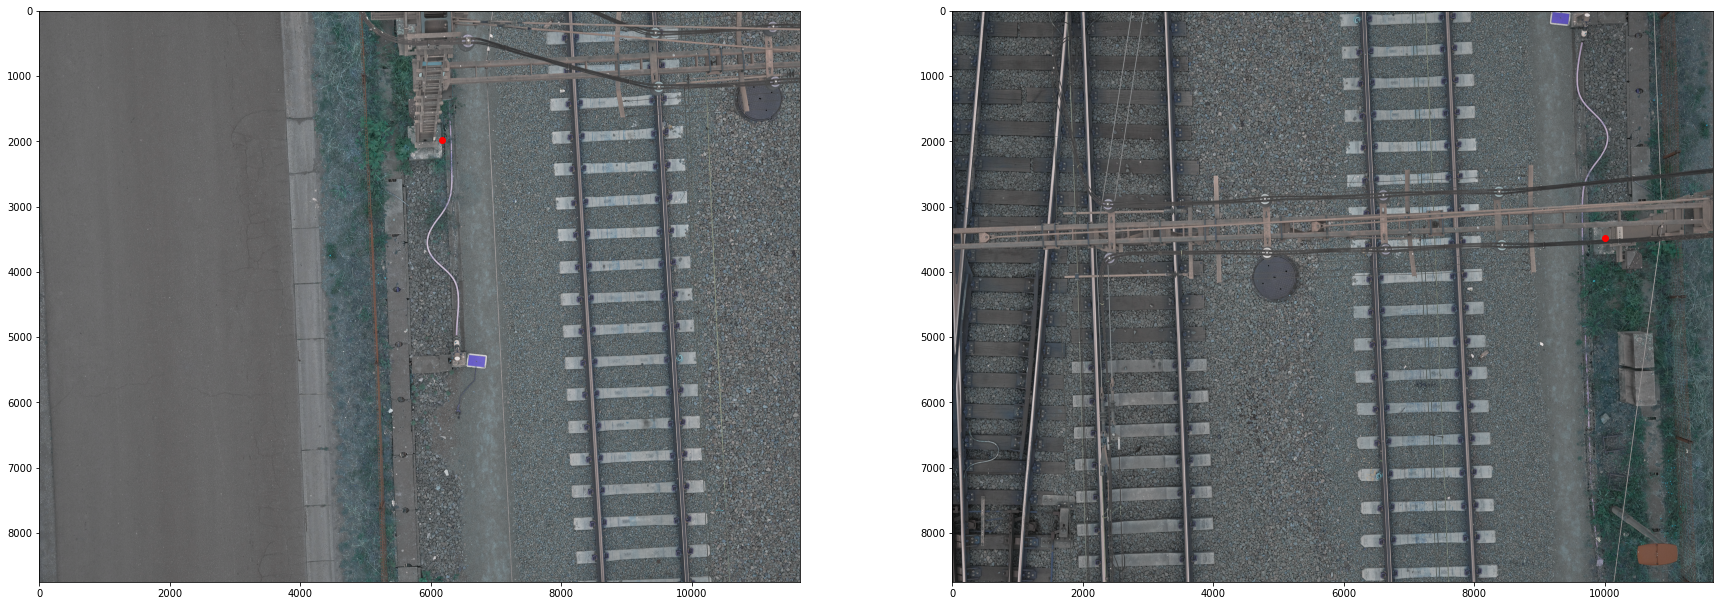

In [78]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2,figsize=(30, 30))

im1=1
im2=2

axs[0].imshow(imgNodes[im1].resource)
axs[0].plot(uvCoordinates[im1][1],uvCoordinates[im1][0], color='red', marker='o',)

axs[1].imshow(imgNodes[im2].resource)
axs[1].plot(uvCoordinates[im2][1],uvCoordinates[im2][0], color='red', marker='o',)
plt.show()

# PROJECT IMAGEPOINTS IN 3D

Get uvCoordinates

In [15]:
uvCoordinates=np.array(copy.deepcopy(uvCoordinates))
uvCoordinates=np.reshape(np.array(uvCoordinates),(len(imgNodes),2))
print(uvCoordinates)

[[ 7361.88535458  6310.70007222]
 [ 1979.50866435  6169.36916335]
 [ 1634.03263573 10003.62678807]
 [ 7069.38248683  9948.14270801]
 [  319.35795697  6107.16389226]
 [ 3482.64219548  9998.85987181]]


transform UV coordinates to world coordinates to rays

In [16]:
rays=np.zeros((1,6))
for n,points in zip(imgNodes,uvCoordinates):
    points=np.array([points])
    rays=np.vstack((rays,n.create_rays(points)))
rays=np.delete(rays,0,axis=0) 
print(rays)

[[ 2.63374763e+05  1.51063706e+05  2.81277422e+02  1.30916999e-01
   2.87608513e-02 -9.90976061e-01]
 [ 2.63380928e+05  1.51064103e+05  2.81282871e+02 -1.20131052e-01
   1.26271618e-02 -9.92677735e-01]
 [ 2.63374334e+05  1.51068993e+05  2.81294884e+02  1.45476750e-01
  -1.82740452e-01 -9.72338646e-01]
 [ 2.63380529e+05  1.51069322e+05  2.81309533e+02 -1.01939962e-01
  -1.96303391e-01 -9.75229831e-01]
 [ 2.63382830e+05  1.51064246e+05  2.81283450e+02 -1.95275252e-01
   6.71722984e-03 -9.80725474e-01]
 [ 2.63376474e+05  1.51069102e+05  2.81302900e+02  6.05658067e-02
  -1.88520879e-01 -9.80199807e-01]]


(optional) cast rays for custom set of rays such as the image size

In [158]:
# start an array of rays () -> tensor
rays=np.zeros((1,6))
for n in imgNodes:
    # example uv points (top left, middle and bottom right)
    uvCoordinates=np.array([[0,0], # top left
                            [0,n.imageWidth], # top right
                            [np.floor(n.imageHeight/2),np.floor(n.imageWidth/2)], #middle
                            [n.imageHeight,0], # bottom left
                            [n.imageHeight,n.imageWidth] # bottom right
                            ])
    # transform uvcoordinates  to world coordinates to rays   
    rays=np.vstack((rays,n.create_rays(uvCoordinates)))

    # cast rays to 3D mesh -> this is slow if you do it for every node
    # distances,_=gmu.compute_raycasting_collisions(pcdNode.resource,rays)
    # # #compute endpoints 
    # _,endpoints=gmu.rays_to_points(rays,distances)
    # print(rays)
    # print(uvCoordinates)
rays=np.delete(rays,0,axis=0) 

visualize rays

In [167]:
# array=np.vstack([n.ray for n in damageCandidateNodes])
# darray=np.vstack([np.reshape(n.distances,(distances.shape[0],1)) for n in damageCandidateNodes])
line_set=gmu.rays_to_lineset(rays,50)
# # line_set.colors=o3d.utility.Vector3dVector(np.vstack((np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1]),np.zeros((len(line_set.lines)-3,3)))))
o3d.visualization.draw_geometries([line_set]+[joinedImages]+[meshNode.resource])

# CREATE RDF GRAPH OF IMAGES

An RDF graph and .ttl file is created for all nodes 
(data itself is not stored in the graph, only metadata)

In [173]:
imgGraph=tl.nodes_to_graph(imgNodes,imgGraphPath,save=True)
print (f'{len(imgNodes)} Nodes succesfully serialized in: {imgGraphPath}')

6 Nodes succesfully serialized in: D:/Data/TUCRAIL/cameras_L72_0312.ttl


# PARSE IMAGEGRAPH

In [24]:
nodeList=tl.graph_path_to_nodes(imgGraphPath)
print(len(nodeList))

6


c:\Users\u0094523\.conda\envs\conda_environment3\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (102060000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [33]:
node

In [34]:
# node=next(n for n in imgNodes if n.subject.toPython == 'file:///f988d9e1-e362-11ed-86b8-c8f75043ce59')
node=imgNodes[0]

subimages,_=iu.subdivide_image(node.resource,m=3,n=3)
tileNodes=[]
for img in subimages:
    tileNodes.append(ImageNode(resource=img,
                               isDerivedFrom=node.subject))

In [38]:
# these are subdivided tiles
tileNodes=tileNodes

# find unique imgNodes among the tiles
uniqueImgNames=list(set([n.isDerivedFrom for n in tileNodes]))
print(uniqueImgNames)

# per unique image Name, group all tileNodes and construct image
for name in uniqueImgNames:
    #give me all the nodes that match isDerived to that unique name
    nodeList=[n for n in tileNodes if n.isDerivedFrom==name]
    coordinateArray=[]
    
    #gather all the coordinates per node in nodeList
    for n in nodeList:
        coordinates=n.suzannaPoints # these your coordinates
        roi= n.roi # these are the roi's
        coordinates=list(coordinates+roi) # this will be wrong
        coordinateArray.extend(coordinates)        
    coordinateArray=np.array(coordinateArray)
    
    
    
    # make a lineSet3D
    lineset=o3d.geometry.LineSet()
    lineset.points(o3d.utility.Vector3dVector(coordinateArray)) # (x,y,) list of coordinates
    lineset.lines()
    
    #get the original image
    imgNode=next(n for n in imgNodes if n.subject==name)   
    #assign those points/lines to the original image
    imgNode.coordinateArray=
    imgNode.lineset= coordinateArray  [0,1] -> [500,501]# relatief benaamd 
    

[rdflib.term.URIRef('file:///f988d9e1-e362-11ed-86b8-c8f75043ce59')]
9


In [ ]:
print(node)

In [30]:
n.subject

rdflib.term.URIRef('file:///f988d9e1-e362-11ed-86b8-c8f75043ce59')

In [25]:
{key:value for key, value in nodeList[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 11664,
 'imageHeight': 8750,
 'focalLength35mm': 21276.5957031249,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///06332674-d1f2-11ed-8fc0-c8f75043ce59'),
 '_graph': <Graph identifier=Nfaf7d018044e4422b740211d253ab44f (<class 'rdflib.graph.Graph'>)>,
 '_graphPath': 'D:/Data/TUCRAIL/cameras_L72_0312.ttl',
 '_path': 'D:/Data/TUCRAIL\\P0024624.jpg',
 '_name': 'P0024624',
 '_timestamp': '2023-04-03T09:33:08',
 '_resource': None,
 '_cartesianTransform': array([[-8.35427289e-02,  1.91778056e+00, -1.50033543e-02,
          2.63382830e+05],
        [ 1.91783298e+00,  8.35783123e-02,  4.25654402e-03,
          1.51064246e+05],
        [ 4.90559907e-03, -1.48038476e-02, -1.91959464e+00,
          2.81283450e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'type': 'https://w3id.org/v4d/core#ImageNode',
 'intrinsic_matrix': '[[2.12765

## check subdivision image

In [12]:
n=imgNodes[0]
import matplotlib.pyplot as plt


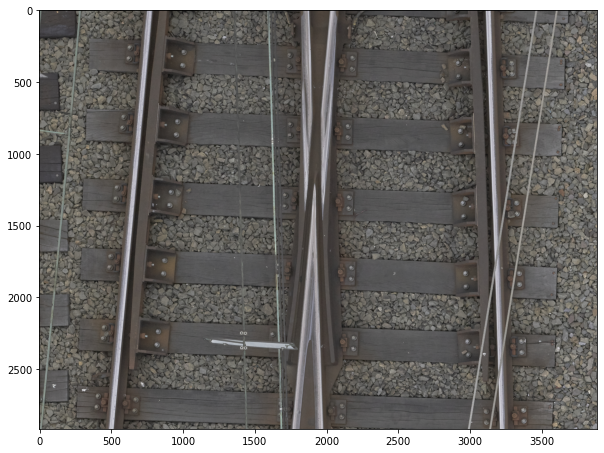

In [35]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(tileNodes[0].resource, cv2.COLOR_BGR2RGB))

In [15]:
roiList,roiBounds=iu.subdivide_image(n.resource,m=3,n=3)
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(n.resource[roiBounds[3][0]:roiBounds[3][1],roiBounds[3][2]:roiBounds[3][3]], cv2.COLOR_BGR2RGB))     
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(roiList[3], cv2.COLOR_BGR2RGB))

In [18]:
print(roiBounds)

[(0, 2916, 0, 3887), (0, 2916, 3888, 7775), (0, 2916, 7776, 11663), (2917, 5833, 0, 3887), (2917, 5833, 3888, 7775), (2917, 5833, 7776, 11663), (5834, 8749, 0, 3887), (5834, 8749, 3888, 7775), (5834, 8749, 7776, 11663)]


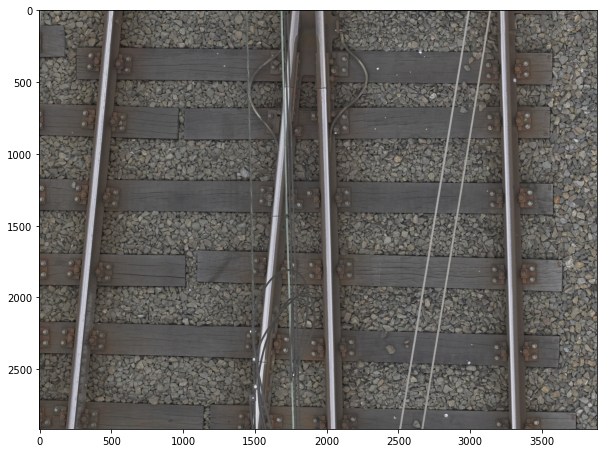

In [23]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(n.resource[roiBounds[3][0]:roiBounds[3][1],roiBounds[3][2]:roiBounds[3][3]], cv2.COLOR_BGR2RGB))

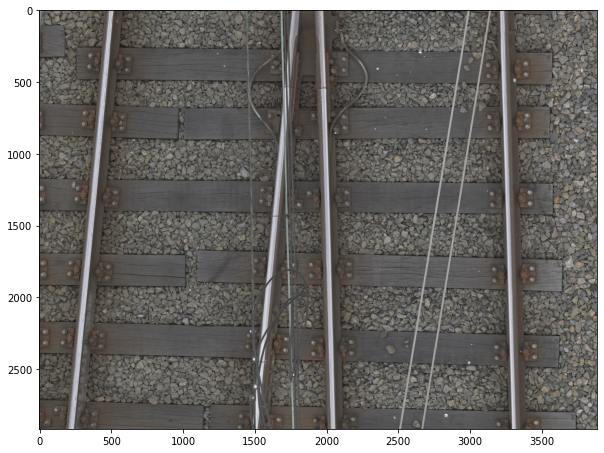

In [22]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(roiList[3], cv2.COLOR_BGR2RGB))